# Proyecto: Clustering  de clientes

Integrantes:

- Gloria Cadavid - CC. 1152187908
- Jose Herrera - CC. 1037645513
- Stefania Nieto - CC. 1017239733

## Motivación

1. Implementar métodos para identificar grupos o clusters en el conjunto de datos seleccionado.
2. Comprender las características de los diferentes grupos de clientes para realizar la segmentación o creación de nuevos productos.


### Contexto

Considerance el contexto económico actual, se requiere desarrollar nuevos productos ajustados a los perfiles de los clientes actuales.

### Objetivo

Comprender las características principales de los clientes actuales para el desarrollo de productos que sean rentables, considerando las abstracciones del análisis.


## Descripción del dataset

1. Fuente de datos: dataset obtenido en [Kaggle](https://www.kaggle.com/datasets/vishakhdapat/customer-segmentation-clustering). Contiene información personal y de consumo de 2240 individuos.
2. Variables: 
    - ID: ID para cada individuo en el dataset
    - Year_Birth: año de nacimiento
    - Education: grado de escolaridad más alto
    - Marital_Status: estado civil
    - Income: ingresos anuales
    - Kidhome: número de niños en el hogar
    - Teenhome: número de adolescentes en el hogar
    - Dt_Customer: fecha en que se inscribió el usuario
    - Recency: número de días desde la última compra o interacción
    - MntWines: dinero gastado en vino
    - MntFruits: dinero gastado en frutas
    - MntMeatProducts: dinero gastado en carnes
    - MntSweetProducts: dinero gastado en dulces
    - MntGoldProds: dinero gastado en oro
    - NumDealsPurchases: número de compras con descuento
    - NumWebPurchases: número de compras por internet
    - NumCatalogPurchases: número de compras por catálogo
    - NumStorePurchases: número de compras en tiendas físicas
    - NumWebVisitsMonth: número de visitas al sitio web de la compañía
    - AcceptedCmp3: indicador binario de si el usuario aceptó la tercera campaña de marketing
    - AcceptedCmp4: indicador binario de si el usuario aceptó la cuarta campaña de marketing
    - AcceptedCmp5: indicador binario de si el usuario aceptó la quinta campaña de marketing
    - AcceptedCmp1: indicador binario de si el usuario aceptó la primera campaña de marketing
    - AcceptedCmp2: indicador binario de si el usuario aceptó la segunda campaña de marketing
    - Complain: indicador binario de si la persona ha presentado una queja
    - Z_CostContact: coste constante asociado al contacto con un cliente
    - Z_Revenue: ingresos constantes asociados a una respuesta satisfactoria de la campaña
    - Response: indicador binario de si el usuario respondió a la campaña de marketing.



In [1]:
# Importación de las bibliotecas necesarias
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(42)

# Importación de módulos específicos de scikit-learn para tareas de machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

# Importación de módulos de Yellowbrick para visualización de modelos de machine learning
from yellowbrick.features import PCA as yb_pca
from yellowbrick.features import pca_decomposition
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Limpieza y exploración de datos

En este punto se procede a cargar el dataset y hacer una exploración de los datos. Se revisa la información de cada columna, su tipo y la existencia de valores nulos; si es necesario se transforma la columna al tipo correcto de datos y se hace tratamiento de valores nulos. Para el atributo "Income", por ejemplo, se hace imputación de valores usando el valor promedio agrupado por "Education".

In [2]:
# Lectura y copia de dataset
clientes_raw = pd.read_csv(r"..\data\raw\customer_segmentation.csv")
clientes = clientes_raw.copy()

# Información de los tipos de columnas. Solo la columna Income contiene valores nulos.
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
# Visualización de las primeras filas del dataset
clientes.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
#Validación de IDs duplicados
clientes[clientes.duplicated(subset='ID', keep= False)]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response


In [5]:
# Revisión de filas con valores nulos
clientes[clientes.isna().any(axis = 1)].head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,15-11-2013,11,5,...,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,20-02-2013,19,5,...,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,05-11-2013,80,81,...,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,01-01-2014,96,48,...,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,17-06-2013,57,11,...,6,0,0,0,0,0,0,3,11,0


In [6]:
# Se imputan los valores nulos del atributo income de acuerdo a la media por "Education"
clientes['Income'] = clientes['Income'].fillna(
    clientes.groupby(by=['Education'])['Income'].transform('mean'))

Dentro del análisis exploratorio se visualiza la correlación que hay entre las variables. Se observa una lógica correlación positiva entre el ingreso anual de los individuos y el monto gastado en cada categoría de producto, también una correlación positiva con compras por todos los medios excepto compras con descuento. Adicionalmente, hay una correlación negativa entre los ingresos anuales y la cantidad de niños en el hogar.

Una correlación negativa interesante se observa entre la cantidad de visitas al sitio web de la compañía y atributos como el income, monto gastado en productos y cantidad compras por diferentes medios.

Text(0.5, 1.0, 'Gráfica de correlación')

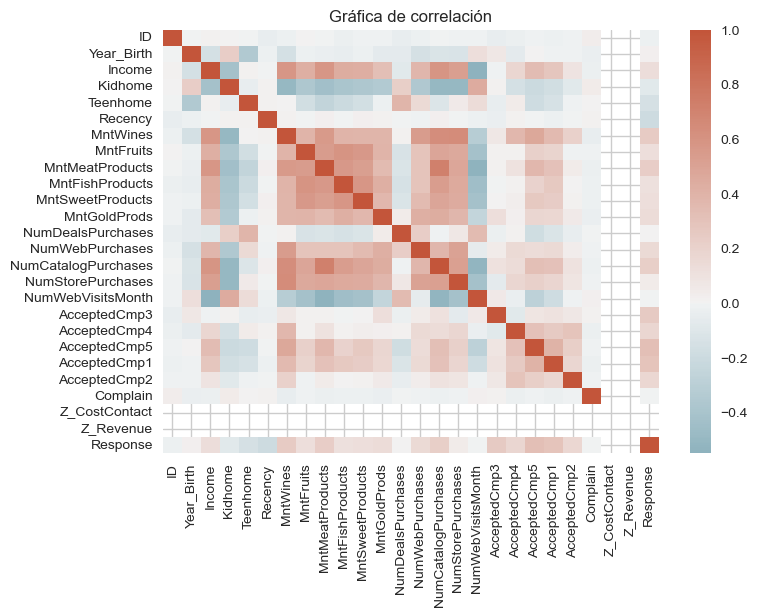

In [7]:

cpal = sns.diverging_palette(h_neg=220, h_pos=20, as_cmap=True)
sns.heatmap(clientes.select_dtypes(
    include=np.number).corr(), center=0, cmap=cpal).set_title("Gráfica de correlación")

In [8]:
clientes['Dt_Customer'] = pd.to_datetime(
    clientes['Dt_Customer'], format='%d-%m-%Y')
clientes['Complain'] = clientes['Complain'].astype(str).astype('category')
clientes['Response'] = clientes['Response'].astype(str).astype('category')
clientes['Education'] = clientes['Education'].astype('category')
clientes['Marital_Status'] = clientes['Marital_Status'].astype('category')
clientes['ID'] = clientes['ID'].astype('category')

## Metodología

### Ingeniería de atributos

Un paso importante antes de crear un modelo de machine learning es la ingeniería de atributos, el cual consta de diferentes procesos como la creación de nuevas características, la codificación o estandarización de atributos y la reducción de dimensiones. La aplicación de uno o otro tipo de ingeniería de atributos depende del dataset, la distribución de sus atributos y la pertinencia en cuanto al escenario planteado.

In [9]:
# Creación de nuevos atributos a partir de características existentes en el dataset.
clientes["TotalAcceptedCmp"] = clientes["AcceptedCmp1"] + clientes["AcceptedCmp2"] + \
    clientes["AcceptedCmp3"] + \
    clientes["AcceptedCmp4"] + clientes["AcceptedCmp5"]

current_year = clientes['Dt_Customer'].max().year
clientes['Age'] = current_year - clientes['Year_Birth']

clientes['dias registrados'] = (
    clientes['Dt_Customer'].max() - clientes['Dt_Customer']).dt.days

clientes["MntTotal"] = clientes["MntFishProducts"] + clientes["MntFruits"] + clientes["MntGoldProds"] + \
    clientes["MntMeatProducts"] + \
    clientes["MntSweetProducts"] + clientes["MntWines"]

clientes["NumPurchases"] = clientes["NumCatalogPurchases"] + \
    clientes["NumDealsPurchases"] + \
    clientes["NumStorePurchases"] + clientes["NumWebPurchases"]

Se remueven atributos que no sean relevantes (por ejemplo Z_Revenue, Z_CostContact contienen valores constantes) o que hayan sido usadas para la creación de nuevas características y ya no se consideren necesarias.

In [10]:
print(clientes.Z_Revenue.value_counts())
print(clientes.Z_CostContact.value_counts())
clientes = clientes.drop([], axis=1)

Z_Revenue
11    2240
Name: count, dtype: int64
Z_CostContact
3    2240
Name: count, dtype: int64


In [11]:
clientes = clientes.drop(['Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue',
                         "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",
                          "AcceptedCmp5"], axis=1)

En la columna Age hay valores atípicos que no tienen lógica (usuarios mayores de 110 años) o que por ser extremos podrían afectar el resultado del modelo estadístico a ser usado (Income mayo a 600000). Los valores Alone, Absurd y YOLO tienen una proporción mínima en el dataset, además de que no son significativos. Se proceden a eliminar las filas asociadas.

In [12]:
clientes.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalAcceptedCmp,Age,dias registrados,MntTotal,NumPurchases
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52253.592375,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.297768,45.194196,353.582143,605.798214,14.862054
std,25039.085601,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.678381,11.984069,202.122512,602.249288,7.677173
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,5.000000,0.000000
25%,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,37.000000,180.750000,68.750000,8.000000
50%,51609.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,44.000000,355.500000,396.000000,15.000000
75%,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,55.000000,529.000000,1045.500000,21.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,4.000000,121.000000,699.000000,2525.000000,44.000000


In [13]:
clientes['Age'].sort_values(ascending=False)

239     121
339     115
192     114
1950     74
424      73
       ... 
696      19
747      19
995      19
1170     18
46       18
Name: Age, Length: 2240, dtype: int64

In [14]:
clientes['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [15]:
clientes['Income'].sort_values()

1245      1730.0
21        2447.0
1524      3502.0
1846      4023.0
1975      4428.0
          ...   
164     157243.0
1300    157733.0
687     160803.0
617     162397.0
2233    666666.0
Name: Income, Length: 2240, dtype: float64

In [16]:
clientes = clientes[clientes['Age'] < 114]
clientes = clientes[clientes['Income'] < 600000]
clientes = clientes[~clientes['Marital_Status'].isin(
    ['Alone', 'Absurd', 'YOLO'])]
clientes["Marital_Status"] = clientes["Marital_Status"].cat.remove_unused_categories()

Teniendo los atributos y filas que se usarán para crear las agrupaciones, se realizan los siguientes procesamientos:

- Codificación de atributos categóricos: se aplica OneHotEncoder a las columnas categóricas, como resultado se crea una nueva columna binaria para cada categoría que indica la presencia o no de dicha categoría para cada fila.
- Estandarización de atributos numéricos: se aplica StandardScaler eliminando la media y escalando los datos de forma que su varianza sea igual a 1.

In [17]:
clientes = clientes.set_index('ID')

# Se crea una lista con columnas que no necesitan codificación
col_nocod = ['Complain', 'Response']

# Lista de columnas categóricas que necesitan ser codificadas
col_cat = clientes.drop(col_nocod, axis=1).select_dtypes(
    exclude=np.number).columns
# Lista de atributos numéricos
col_num = clientes.select_dtypes(include=np.number).columns

# Codificación de variables categóricas usando OneHotEncoder
codificador = OneHotEncoder()

columnas_codificadas = codificador.fit_transform(clientes[col_cat]).toarray()

clientes_codificado = pd.DataFrame(
    columnas_codificadas, index=clientes.index, columns=codificador.get_feature_names_out(col_cat))

# Normalización de variables numéricas usando StandardScaler
escalador = StandardScaler()
columnas_estandarizadas = escalador.fit_transform(clientes[col_num])
clientes_estandarizados = pd.DataFrame(
    columnas_estandarizadas, index=clientes.index, columns=col_num)

# Se concatenan todas las columnas procesadas en un nuevo dataset
clientes_procesado = pd.concat(
    [clientes_estandarizados, clientes_codificado, clientes[col_nocod].astype(float)], axis=1)

### Reducción de dimensionalidad

Algunos de estos atributos pueden estar muy correlacionados, por lo que serían redundantes. Debido a esto, se analiza si es necesario reducir la cantidad de dimensiones antes de entrenar el modelo.

El análisis de componentes principales (PCA) es una técnica para reducir la dimensionalidad a una cantidad menor de componentes que retengan la mayor parte de la información, mediante la transformación de variables correlacionadas.

De acuerdo a la gráfica, no se puede reducir este dataset a un número considerablemente menor de componentes sin perder una gran cantidad de información. Por ejemplo, al reducirlo a 10 componentes se explica un 80 % de la varianza. En este caso se decide entrenar el modelo usando todas las variables existentes.

[Text(0.5, 1.0, 'Varianza explicada acumulada por componentes'),
 Text(0.5, 0, 'Número de componentes'),
 Text(0, 0.5, 'Varianza explicada acumulada')]

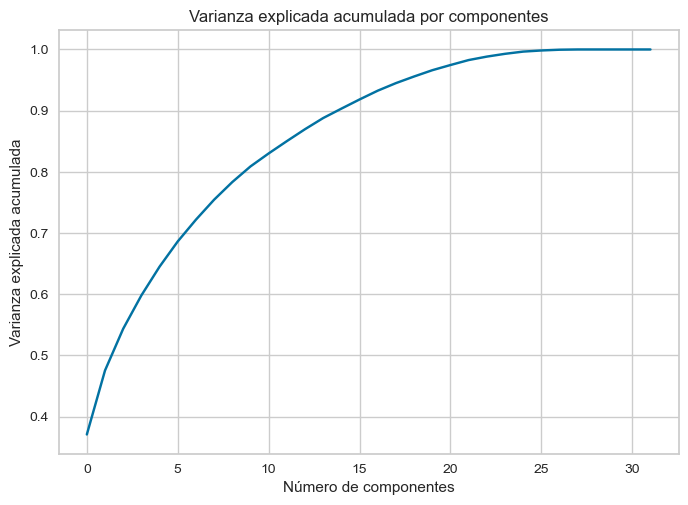

In [18]:
pca = PCA(random_state=100)
pca.fit(clientes_procesado)
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)
sns.lineplot(varianza_acumulada).set(title="Varianza explicada acumulada por componentes",
                                     xlabel='Número de componentes', ylabel='Varianza explicada acumulada')

## Selección del algoritmo

Para realizar la agrupación de clientes se usará el algoritmo de clustering K-medias el cual identifica grupos de casos relativamente homogéneos basándose en las características seleccionadas. Este algoritmo requiere que se especifique el número de clústeres, con este fin existen diferentes métodos:

- Método del codo: consiste en graficar la varianza explicada por diferentes números de clusters e identificar el "codo", donde la tasa de varianza disminuye rápidamente y se nivela, lo que sugiere un recuento de clusters adecuado para el análisis o el entrenamiento del modelo.
- Análisis de siluetas: 
- Distancia interclusters

De acuerdo al método del codo para este dataset el número de clústers idóneo es 4. Usando los otros métodos se pueden comparar los resultados usando 4 o 5 clusters.

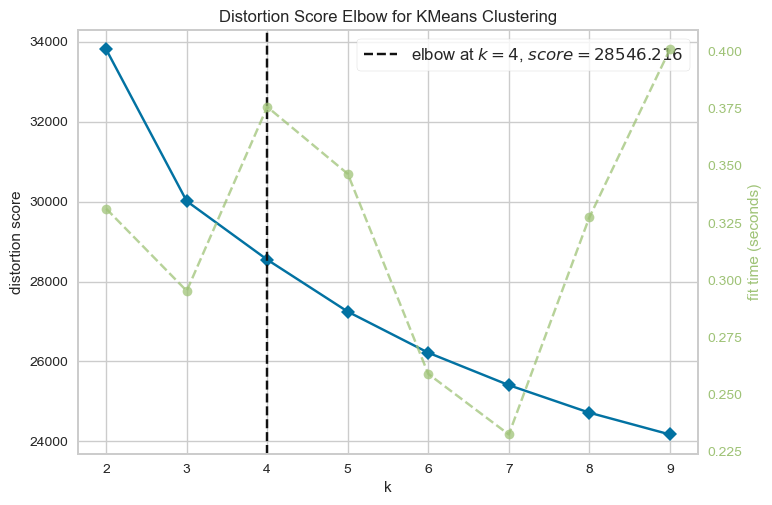

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
Elbow_M = KElbowVisualizer(KMeans(random_state=100), k=(2, 10))
Elbow_M.fit(clientes_procesado)
Elbow_M.show()

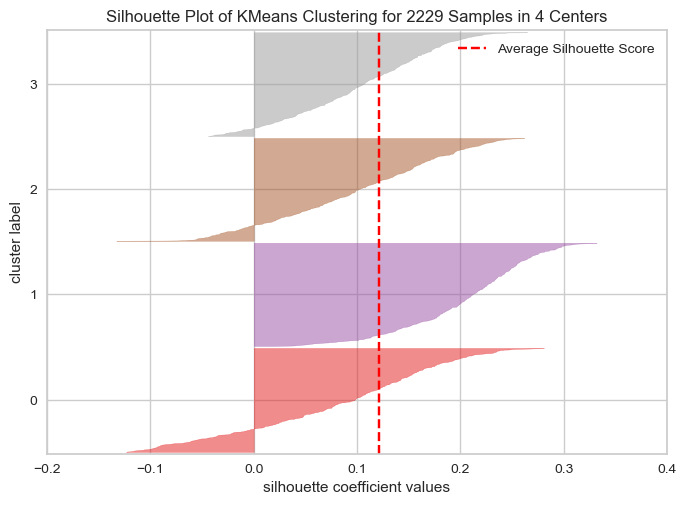

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2229 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
Sil_M = SilhouetteVisualizer(KMeans(4, random_state=100))
Sil_M.fit(clientes_procesado)
Sil_M.show()

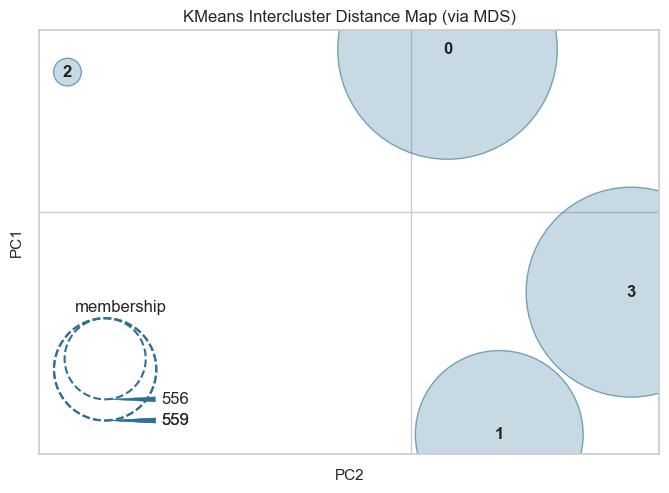

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [21]:
Inter_M = InterclusterDistance(KMeans(4, random_state=100))
Inter_M.fit(clientes_procesado)
Inter_M.show()

Luego de analizar los métodos mencionados, se decide entrenar el algoritmo k-means usando 4 clusters.

In [22]:
# Se inicializa el algoritmo k-means usando 4 clusters
KM = KMeans(n_clusters=4, random_state=100)
# Entrenar el modelo y predecir los clusters
yhat_KM = KM.fit_predict(clientes_procesado)
# Añadir el atributo de clusters al dataset original
clientes_procesado["cluster"] = yhat_KM
clientes_procesado = clientes_procesado.sort_values("cluster")
clientes["cluster"] = yhat_KM

Se grafica cada dato en dos dimensiones (usando el algoritmo PCA) para visualizar rápidamente la distribución de los clusters en estos componentes principales.

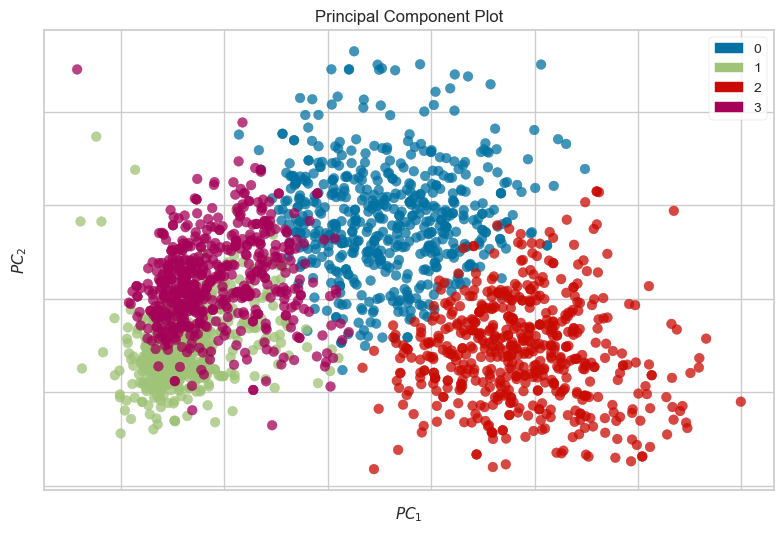

PCA(ax=<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>,
    classes=array([0, 1, 2, 3]),
    colors=[(0.00784313725490196, 0.4470588235294118, 0.6352941176470588),
            (0.6235294117647059, 0.7647058823529411, 0.4666666666666667),
            (0.792156862745098, 0.043137254901960784, 0.011764705882352941),
            (0.6470588235294118, 0.00784313725490196, 0.34509803921568627)])

In [23]:
cluster_colors = sns.color_palette(n_colors=4)
# Grafica de cada punto y su cluster asociado en los dos componentes principales
pca_decomposition(
    clientes_procesado.drop("cluster", axis=1), clientes_procesado["cluster"],
    scale=True, classes=clientes_procesado["cluster"].unique(),
    colors=cluster_colors,
)

Las características que más importancia tienen en el PC1 es MntTotal, Income, NumPurchases, NumCatalogPurchases y MntWines; mientras que el para el PC2 son las características NumDealsPurchases, Teenhome, NumWebPurchases, NumPurchases y Age.

In [24]:
pca_components = yb_pca(scale=True, projection=2, random_state=100).fit(
    clientes_procesado.drop("cluster", axis=1), clientes_procesado["cluster"]).pca_components_

pca_detail = pd.DataFrame(pca_components, columns=clientes_procesado.drop(
    "cluster", axis=1).columns, index=["PC1", "PC2"]).T
plt.close("all")

In [25]:
pca_detail.sort_values("PC1", key=abs, ascending=False)[["PC1"]].head()

,PC1
MntTotal,0.335581
Income,0.298493
NumPurchases,0.296203
NumCatalogPurchases,0.291136
MntWines,0.284705


In [26]:
pca_detail.sort_values("PC2", key=abs, ascending=False)[["PC2"]].head()

,PC2
NumDealsPurchases,0.458812
Teenhome,0.451317
NumWebPurchases,0.302345
NumPurchases,0.272531
Age,0.271179


## Resultados

[Text(0, 0, '560'), Text(0, 0, '556'), Text(0, 0, '554'), Text(0, 0, '559')]

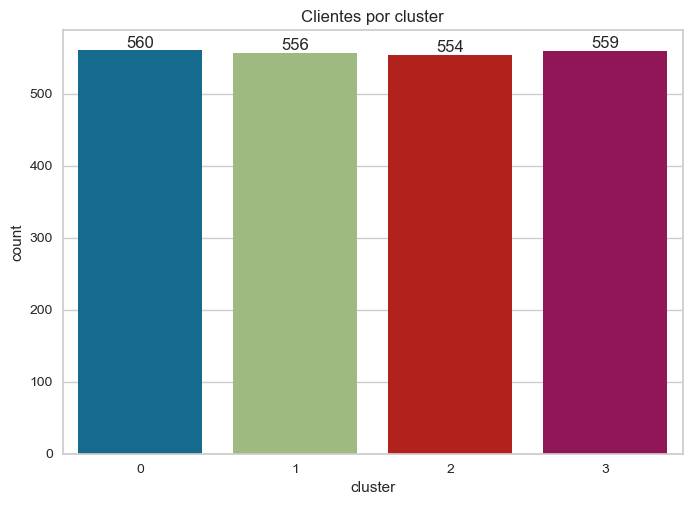

In [27]:
ax = sns.countplot(x=clientes_procesado["cluster"], palette=cluster_colors)
ax.set_title("Clientes por cluster")
ax.bar_label(ax.containers[0])

In [28]:
fig, axes = plt.subplots(
    nrows=6, ncols=4, constrained_layout=True, figsize=(30, 34), sharex=True)
fig.suptitle("Análisis de atríbutos por cluster")
plt.close("all")

In [29]:
for i, col in enumerate(clientes.columns[:-1]):
    nrow = i//4
    ncol = i % 4
    if col in col_num:
        sns.boxplot(data=clientes, x="cluster", y=col, ax=axes[nrow, ncol])
    else:
        sns.countplot(data=clientes, x='cluster', hue=col, ax=axes[nrow, ncol])

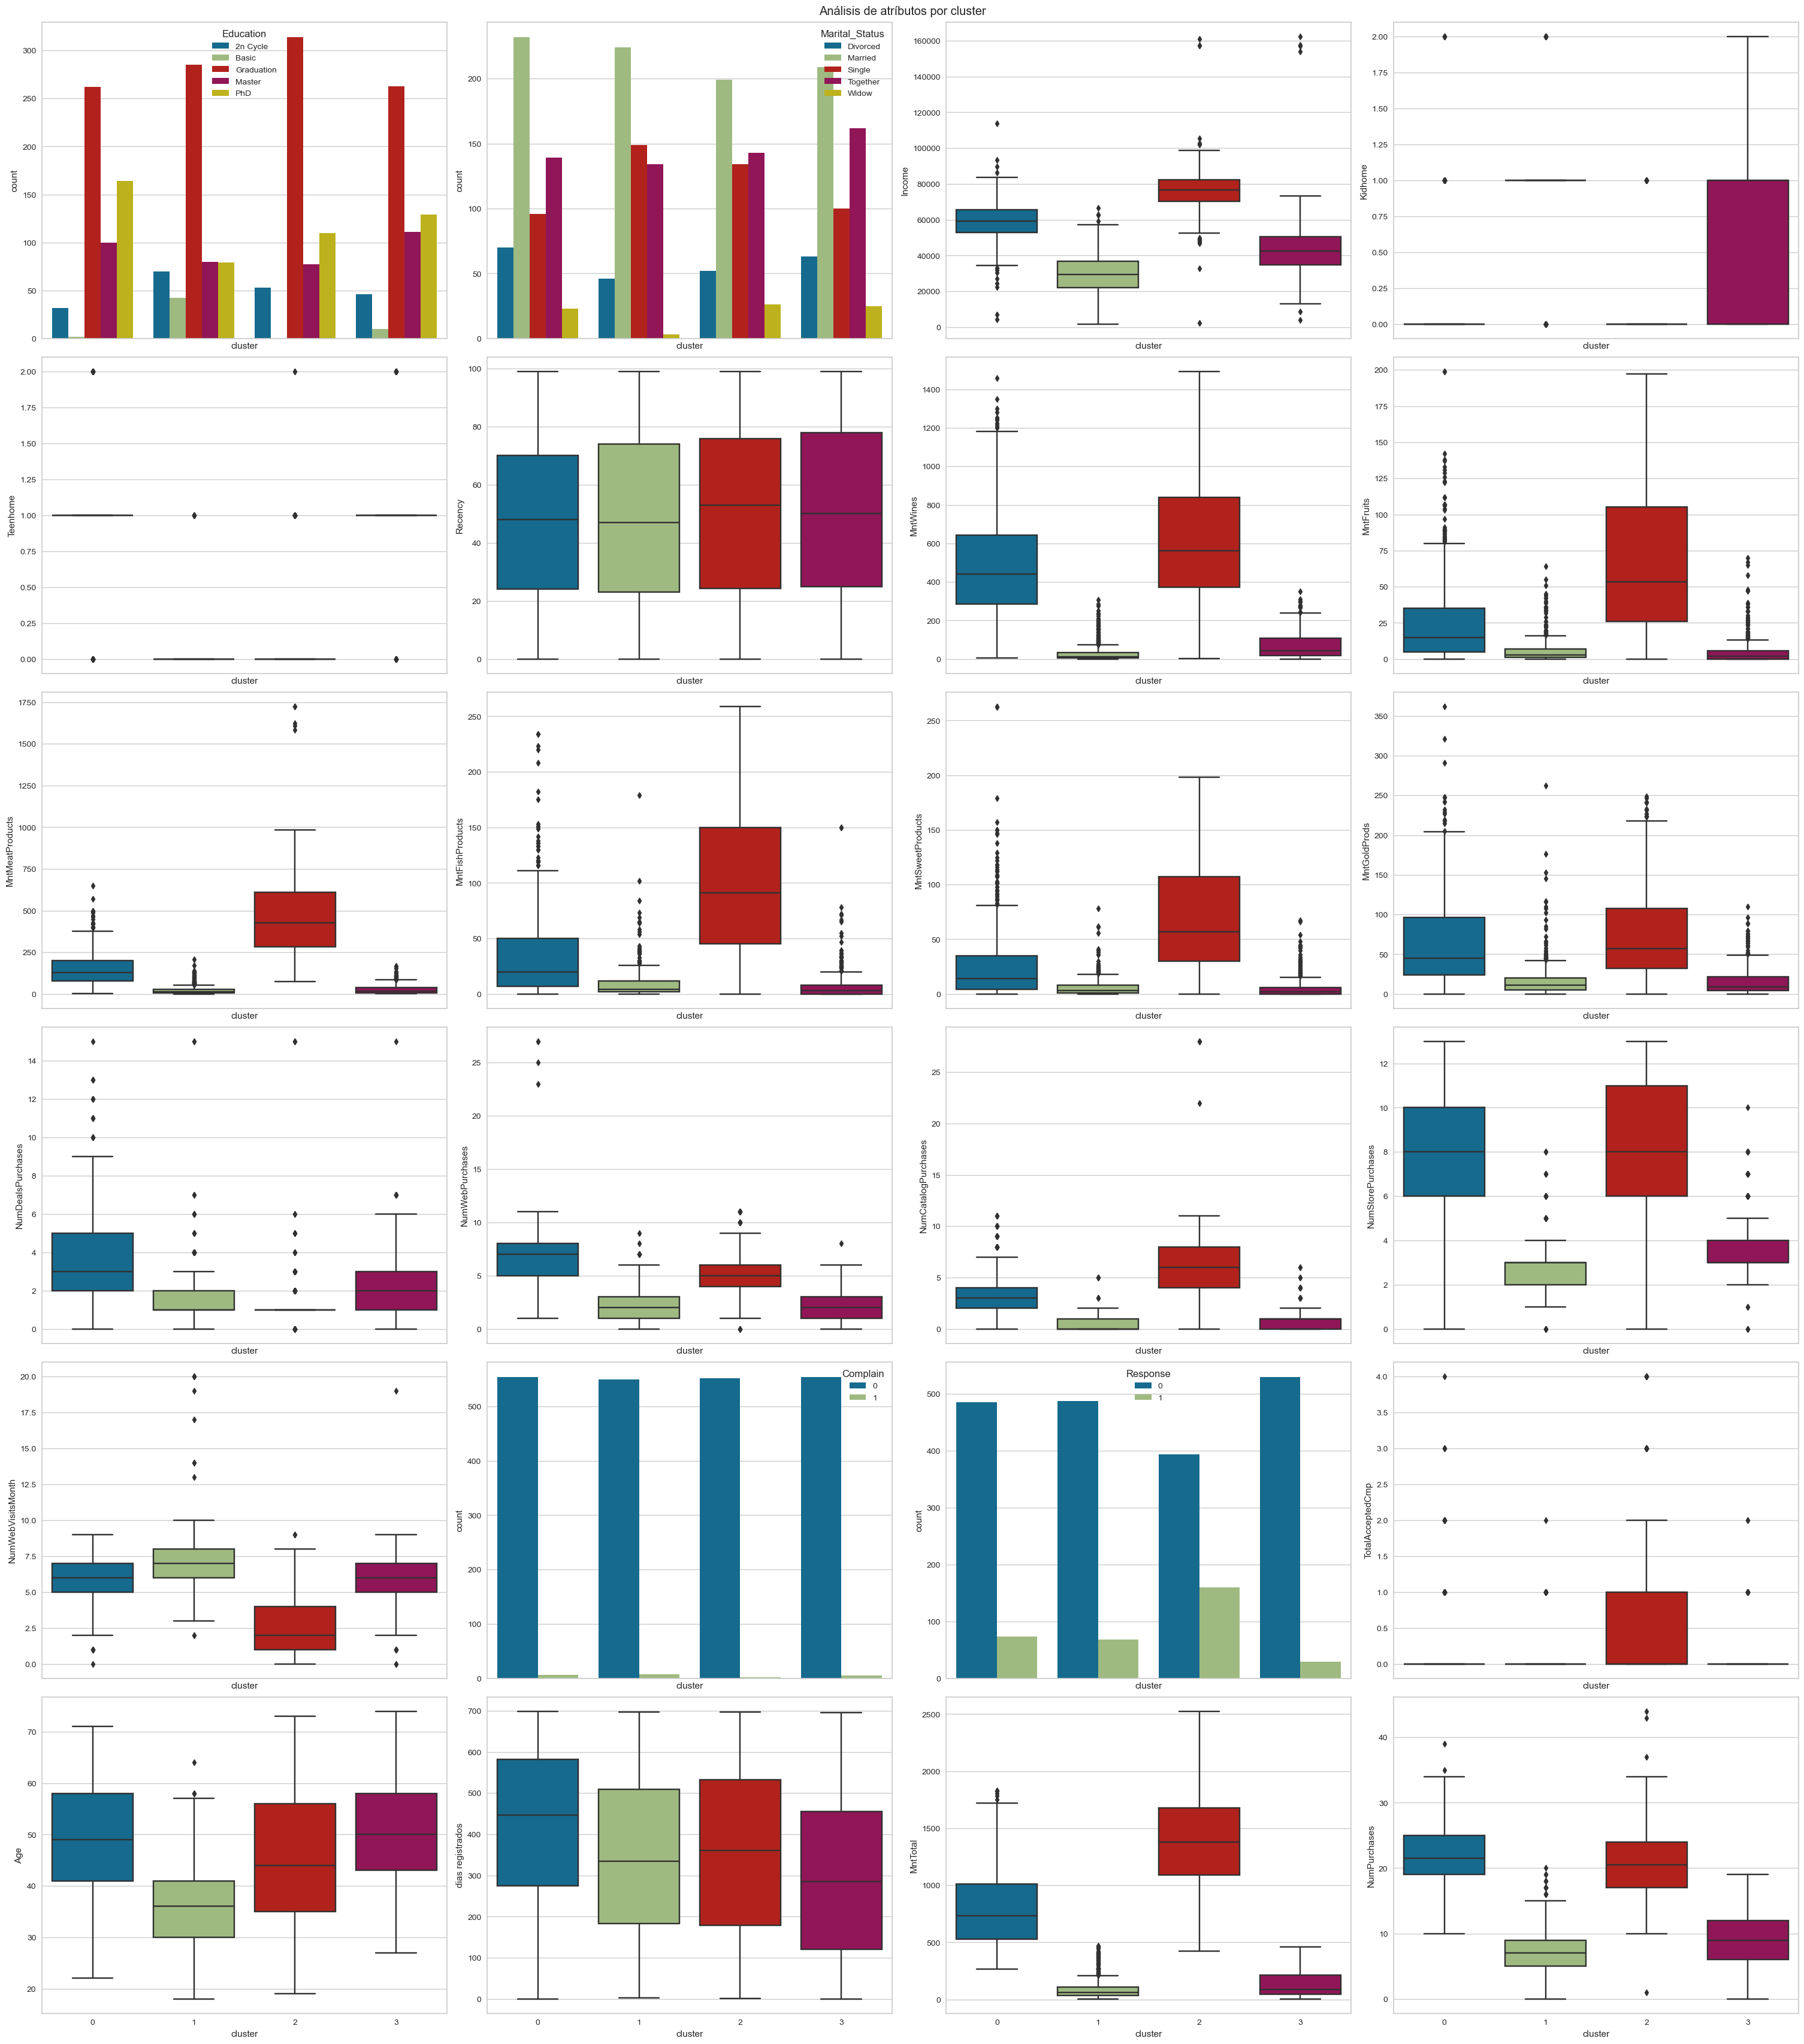

In [30]:
fig